In [2]:
from google.colab import drive
import pandas as pd
import os
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from collections import defaultdict
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
import transformers
from pathlib import Path
import pickle
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import copy
from abc import ABC, abstractmethod
import random
from statistics import mode
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
mount_directory = "/content/drive"
dataset_path = os.path.join(mount_directory, 'MyDrive/MELD/MELD_train_efr.json')
model_card = 'bert-base-uncased'
drive.mount(mount_directory)
initial_seed = 2
seeds = [42, 53, 146, 34, 21]
batch_size = 6
patience = 5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def fit_onehotencoder(data: pd.core.series.Series) -> LabelBinarizer:
  onehotencoder = LabelBinarizer()
  data_flattened = np.concatenate(data.values)
  onehotencoder.fit(data_flattened)
  return onehotencoder

In [5]:
#sbagliato, deve esserci un tokentypeids per ogni token e deve essere riferito a uno speaker particolare
def map_to_order_of_occurrence(data: list) -> list:
    # When a new entry is added, its value is computed using the lambda function
    dict_order_of_occurrence = defaultdict(lambda: len(dict_order_of_occurrence)+1)
    order_of_occurrence = [dict_order_of_occurrence[element] for element in data]
    return order_of_occurrence

In [6]:
def replace_none_with_zero(data: list) -> list:
    return [0 if x is None else x for x in data]

In [7]:
def tokenize_dialogue(dialogue_text: list, tokenizer,  speakers = None) -> list:
    if speakers!=None:
      tokenized_dialogue = [[speakers[idx]] + tokenizer.tokenize(utterance) + [tokenizer.sep_token] for idx, utterance in enumerate(dialogue_text)]
    else:
      tokenized_dialogue = [tokenizer.tokenize(utterance) + [tokenizer.sep_token] for utterance in dialogue_text]
    tokenized_dialogue.insert(0, [tokenizer.cls_token])
    flattened_tokens = [token for sublist in tokenized_dialogue for token in sublist]
    return flattened_tokens

In [8]:
def add_padding(x: list, max_x_length: int, pad_value, pad_length = None) -> list:
    x_length = len(x)
    num_pad_values = max_x_length - x_length
    if pad_length == None:
      padded_x = x + [pad_value] * num_pad_values
    else:
      pad_list = [pad_value] * pad_length
      pad_lists = np.tile(pad_list, (num_pad_values, 1))
      padded_x = np.concatenate((x, pad_lists), axis=0)
    return padded_x

In [9]:
def build_alternative_dialogue(utterances: pd.core.series.Series, speakers: pd.core.series.Series, tokenizer) -> pd.core.series.Series:
  dialogue_column = []
  for dialogue_index, dialogue in utterances.items():
    dialogue_column.append(tokenize_dialogue(dialogue, tokenizer, speakers[dialogue_index]))
  return pd.Series(dialogue_column)

In [10]:
def build_dataframes(df, emotions_encoder, tokenizer):
    column_names = ['emotions', 'speakers', 'triggers', 'dialogues', 'dialogues_ids', 'attention_masks']
    df_standard = pd.DataFrame(columns = column_names)
    df_standard['speakers'] = df['speakers'].apply(lambda x: map_to_order_of_occurrence(x))
    df_standard['emotions'] = df['emotions'].apply(lambda x: emotions_encoder.transform(x))
    df_standard['triggers'] = df['triggers'].apply(lambda x: replace_none_with_zero(x))
    df_variation = copy.deepcopy(df_standard)
    df_standard['dialogues'] = df['utterances'].apply(lambda x: tokenize_dialogue(x, tokenizer))
    df_variation['dialogues'] = build_alternative_dialogue(df['utterances'], df_standard['speakers'], tokenizer)
    return df_standard, df_variation

In [11]:
def split_dataframe(orginal_df: pd.DataFrame, seed: int):
    train, test_validation = train_test_split(orginal_df, test_size=0.2, random_state=seed)
    validation, test = train_test_split(test_validation, test_size=0.5, random_state=seed)
    return train.reset_index(drop=True), validation.reset_index(drop=True), test.reset_index(drop=True)

In [12]:
class CustomDataset(Dataset):
    def __init__(self, speakers: pd.core.series.Series,
                 dialogues:  pd.core.series.Series,
                 emotions:  pd.core.series.Series,
                 triggers:  pd.core.series.Series,
                 device,
                 pad_token: str,
                 max_num_utterances):
        self.max_dialogue_length = dialogues.apply(len).max()
        self.max_num_utterances = max_num_utterances
        self.dialogues = dialogues.apply(lambda x: add_padding(x, self.max_dialogue_length, pad_token))
        self.dialogues_ids = self.dialogues.apply(lambda x: tokenizer.convert_tokens_to_ids(x))
        self.attention_masks = self.dialogues.apply(lambda x: [1 if token != pad_token else 0 for token in x])
        self.speakers = speakers.apply(lambda x: add_padding(x, self.max_num_utterances, pad_value=0))
        num_emotion_classes = len(emotions[0][0])
        self.emotions = emotions.apply(lambda x: add_padding(x, self.max_num_utterances, pad_value = 0, pad_length = num_emotion_classes))
        self.triggers = triggers.apply(lambda x: add_padding(x, self.max_num_utterances, pad_value=0))
        self.device = device

    def __len__(self):
        return len(self.dialogues)

    def __getitem__(self, idx):
        speakers = torch.tensor(self.speakers.iloc[idx], dtype=torch.long).to(device)
        dialogues_ids = torch.tensor(self.dialogues_ids.iloc[idx], dtype=torch.long).to(device)
        dialogues_masks =  torch.tensor(self.attention_masks.iloc[idx], dtype=torch.long).to(device)
        emotions = torch.tensor(self.emotions.iloc[idx], dtype=torch.float32).to(device)
        triggers = torch.tensor(self.triggers.iloc[idx], dtype=torch.float32).to(device)
        return  speakers, dialogues_ids, dialogues_masks, emotions, triggers

In [13]:
def create_dataloader(df: pd.core.frame.DataFrame, device, tokenizer, max_num_utterances, batch_size) -> torch.utils.data.dataloader.DataLoader :
    dataset =  CustomDataset(speakers = df['speakers'],
                                dialogues = df['dialogues'],
                                emotions = df['emotions'],
                                triggers = df['triggers'],
                                device = device,
                                pad_token = tokenizer.pad_token,
                                max_num_utterances = max_num_utterances)
    return DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [14]:
class AbstractModel(ABC, torch.nn.Module):
   def __init__(self, num_emotions, max_num_utterances, device):
        super(AbstractModel, self).__init__()
        self.num_emotions = num_emotions
        self.max_num_utterances =max_num_utterances
        self.device = device

   @abstractmethod
   def forward(self, token_type_ids, input_ids, attention_mask, emotions, triggers):
        pass

In [15]:
class AbstractBERTModel( AbstractModel):
    def __init__(self, model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer, gru_hidden_size = None):
        super(AbstractBERTModel, self).__init__(num_emotions, max_num_utterances, device)

        self.tokenizer = tokenizer
        self.bert_model = BertModel.from_pretrained(model_card).to(device)
        if freeze_embedding_layer:
            self.bert_model.embeddings.requires_grad_(False)
        self.representation_length = self.bert_model.config.hidden_size
        self.emotion_classifier = nn.Sequential(
            nn.Linear(self.representation_length, 1024),
            nn.BatchNorm1d(24),
            torch.nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(24),
            torch.nn.ReLU(),
            nn.Linear(512, self.num_emotions)
        )
        self.gru_hidden_size  = gru_hidden_size
        self.trigger_prediction = self._create_trigger_module()

    @abstractmethod
    def _create_trigger_module(self):
        pass

    def bert_forward(self, input_ids, attention_mask):
        bert_output_1 = self.bert_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        # Extract [SEP] token representations
        sep_indices = (input_ids == self.tokenizer.sep_token_id).nonzero()
        batch_size = input_ids.shape[0]
        sep_representations = torch.zeros((batch_size, self.max_num_utterances, self.representation_length)).to(self.device)
        dialogue_masks = torch.zeros((batch_size, self.max_num_utterances)).to(self.device)
        for idx in range(batch_size):
            sep_indices_idx = sep_indices[sep_indices[:,0] == idx][:,1]
            sep_indices_idx_range = range(len(sep_indices_idx))
            dialogue_masks[idx, sep_indices_idx_range] = 1
            sep_representations[idx, sep_indices_idx_range, :] = bert_output_1[idx, sep_indices_idx, :]
        return sep_representations, dialogue_masks

NON SO SE IL FATTO CHE MOLTIPLICO CON LA DIALOGUE_MASK DIA PROBLEMI PER IL BACKWARD STEP, MAGARI E' EVITABILE. ANCHE NON MOLTIPLICANDO HO LO STESSO RISULTATO.

In [35]:
class CustomBERTModel(AbstractBERTModel):
    def __init__(self, model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer, gru_hidden_size):
        super(CustomBERTModel, self).__init__(model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer, gru_hidden_size)
        self.linear_trigger = nn.Linear(self.gru_hidden_size * 2, 1)


    def _create_trigger_module(self):
        return nn.GRU(
            input_size=self.representation_length + num_emotions + 1,
            hidden_size=self.gru_hidden_size,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, token_type_ids, input_ids, attention_mask, _, __):
        sep_representations, dialogue_masks = self.bert_forward(input_ids, attention_mask)
        emotion_predictions = (self.emotion_classifier(sep_representations) * dialogue_masks.unsqueeze(-1)).to(self.device)
        concatenated_input = torch.cat([sep_representations, emotion_predictions, token_type_ids.unsqueeze(-1)], dim=-1).to(self.device)
        trigger_output, _ = self.trigger_prediction(concatenated_input)
        trigger_output_single_value = self.linear_trigger(trigger_output.to(self.device)).squeeze(-1).to(self.device)
        trigger_output_sigmoid = (torch.sigmoid(trigger_output_single_value) * dialogue_masks).to(self.device)
        return emotion_predictions, trigger_output_sigmoid, dialogue_masks

In [17]:
class BaselineBERTModel(AbstractBERTModel):
    def __init__(self, model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer=False):
        super(BaselineBERTModel, self).__init__(model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer)

    def _create_trigger_module(self):
        return nn.Sequential(
            nn.Linear(self.representation_length, 512),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, _, input_ids, attention_mask, __, ___):
        sep_representations, dialogue_masks = self.bert_forward(input_ids, attention_mask)
        emotion_predictions = self.emotion_classifier(sep_representations).to(self.device)
        trigger_output = self.trigger_prediction(sep_representations).to(self.device)
        trigger_output = trigger_output.squeeze(dim=-1).to(self.device)
        return emotion_predictions, trigger_output, dialogue_masks

In [18]:
class NoGradClassifier(AbstractModel):
    def __init__(self, num_emotions , max_num_utterances, device):
        super(NoGradClassifier, self).__init__(num_emotions, max_num_utterances, device)

    @abstractmethod
    def generate_emotion_index(self):
      pass

    @abstractmethod
    def generate_trigger(self):
      pass

    def _populate_dialogue_masks(_, dialogue_masks, emotions):
        for batch_idx, dialogue in enumerate(emotions):
           for utterance_idx, token in enumerate(dialogue):
              if np.any(token.cpu().numpy()):
                dialogue_masks[batch_idx, utterance_idx] = 1
              else:
                dialogue_masks[batch_idx, utterance_idx] = 0

    def forward(self, _, __, ___, emotions, triggers):
        batch_size = emotions.shape[0]
        dialogue_masks = torch.zeros((batch_size, self.max_num_utterances)).to(self.device)
        self._populate_dialogue_masks(dialogue_masks, emotions)
        emotion_pred = torch.zeros((batch_size, self.max_num_utterances, self.num_emotions)).to(self.device)
        trigger_pred = torch.zeros((batch_size, self.max_num_utterances)).to(self.device)
        for batch_idx, dialogue in enumerate(emotions):
           for utterance_idx, _ in enumerate(dialogue):
               active_index = self.generate_emotion_index()
               one_hot_encoding = np.zeros(self.num_emotions)
               one_hot_encoding[active_index] = 1
               emotion_pred[batch_idx, utterance_idx, :] = torch.tensor(one_hot_encoding)
               trigger_pred[batch_idx, utterance_idx] = self.generate_trigger()
        emotion_pred = (emotion_pred * dialogue_masks.unsqueeze(-1)).to(self.device)
        trigger_pred = (trigger_pred * dialogue_masks).to(self.device)
        return emotion_pred, trigger_pred, dialogue_masks


In [19]:
class RandomClassifier(NoGradClassifier):
    def __init__(self, num_emotions , max_num_utterances, device, seed):
        super(RandomClassifier, self).__init__(num_emotions, max_num_utterances, device)
        np.random.seed(seed)

    def generate_emotion_index(self):
        return np.random.randint(self.num_emotions)

    def generate_trigger(self):
        return random.uniform(0, 1)

In [20]:
class MajorityClassifier(NoGradClassifier):
    def __init__(self, num_emotions , max_num_utterances,device, emotions, triggers):
        super(MajorityClassifier, self).__init__(num_emotions, max_num_utterances, device)
        self.majority_emotion_index = self._compute_majority_emotion_index(emotions)
        self.majority_trigger = self._compute_majority_trigger(triggers)

    def _compute_majority_emotion_index(self,emotions):
        flattened_emotions = self._flatten(emotions)
        flattened_emotions = torch.argmax(flattened_emotions, dim = -1)
        return mode(flattened_emotions)

    def _compute_majority_trigger(self, triggers):
        flattened_triggers = self._flatten(triggers)
        return mode(flattened_triggers)

    def _flatten(self, data):
        flattened_array = []
        for dialogue in data:
          for element in dialogue:
            flattened_array.append(element)
        return torch.tensor(flattened_array).to(self.device)

    def generate_emotion_index(self):
        return self.majority_emotion_index

    def generate_trigger(self):
        return self.majority_trigger

In [21]:
def remove_pad(batch_idx, target, predictions, dialogue_length):
        target_nopad = target[batch_idx, :dialogue_length]
        predictions_nopad = predictions[batch_idx, :dialogue_length]
        return target_nopad, predictions_nopad

def remove_pad_predictions(batch_idx, emotions, emotion_predictions, triggers, trigger_predictions, dialogue_mask):
        dialogue_bool = (dialogue_mask[batch_idx] == 0)
        dialogue_true = dialogue_bool.nonzero()
        if len(dialogue_true) == 0:
          dialogue_length = len(dialogue_mask[batch_idx])
        else:
           dialogue_length = (dialogue_mask[batch_idx] == 0).nonzero()[0][0].item()
        emotions_nopad, emotion_pred_nopad = remove_pad(batch_idx, emotions, emotion_predictions, dialogue_length)
        triggers_nopad, trigger_pred_nopad = remove_pad(batch_idx, triggers, trigger_predictions, dialogue_length)
        return emotions_nopad, emotion_pred_nopad, triggers_nopad, trigger_pred_nopad

def update_metric_arrays(emotions_nopad, emotion_pred_nopad, triggers_nopad, triggers_pred_nopad,
                    emotions_flat, emotions_pred_flat, triggers_flat, triggers_pred_flat,
                    f1_seq_emotions, f1_seq_triggers):
        emotions_flat.extend(emotions_nopad.tolist())
        emotions_pred_flat.extend(emotion_pred_nopad.tolist())
        triggers_flat.extend(triggers_nopad.tolist())
        triggers_pred_flat.extend(triggers_pred_nopad.tolist())
        f1_seq_emotions.append(f1_score(emotions_nopad.cpu().numpy(), emotion_pred_nopad.cpu().numpy(), average = 'micro'))
        f1_seq_triggers.append(f1_score(triggers_nopad.cpu().numpy(), triggers_pred_nopad.cpu().numpy(), average = 'micro'))

def get_metric_results(flattened_emotions, flattened_emotions_pred, flattened_triggers, flattened_triggers_pred, f1_sequence_emotions, f1_sequence_triggers):
        avg_f1_sequence_emotion = sum(f1_sequence_emotions) / len(f1_sequence_emotions)
        avg_f1_sequence_trigger = sum(f1_sequence_triggers) / len(f1_sequence_triggers)
        f1_flattened_emotion = f1_score(flattened_emotions, flattened_emotions_pred, average='micro')
        f1_flattened_trigger = f1_score(flattened_triggers, flattened_triggers_pred, average='micro')
        return avg_f1_sequence_emotion, avg_f1_sequence_trigger, f1_flattened_emotion, f1_flattened_trigger

def turn_into_greedy(emotions, emotion_pred, trigger_pred):
        return torch.argmax(emotions, dim=-1), torch.argmax(emotion_pred, dim=-1), (trigger_pred > 0.5).float()

def discrete_to_onehot(discrete_values, num_classes):
    one_hot_encoded = torch.zeros(len(discrete_values), num_classes)
    one_hot_encoded[torch.arange(len(discrete_values)), discrete_values] = 1
    return one_hot_encoded

def show_confusion_matrix(cm, emotions):
      plt.figure(figsize=(8, 6))
      sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                  xticklabels=np.unique(emotions),
                  yticklabels=np.unique(emotions))
      plt.title('Confusion Matrix')
      plt.xlabel('Predicted')
      plt.ylabel('True')
      plt.show()

Nel caso di CrossEntropyLoss, devo levare le PAD PREDICTIONS (non le voglio proprio no).


Con torch.nn.BCELoss() lui si aspetta che le mie predictions siano GIA' SIGMOIDATE (tra 0 e 1). Nel caso in cui ho pad predictions e pad targets come nel caso qua sotto, il risultato e' giustamente 0. Il problema sta nel fatto che se devo fare AVERAGE di tutti i risultati, NON MI VA BENE che nel numero di esempi col quale poi andare a dividere RISULTI anche l'esempio PADDATO (che mi abbasserebbe la media, facendo aumentare il valore del denominatore).

In [29]:
class CustomTraining():
    def __init__(self, training_loader,validation_loader,test_loader,  device: str,epochs=15,seed=42, onehotencoder= None):
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.test_loader = test_loader
        self.epochs = epochs
        self.device = device
        self.seed = seed
        self.onehotencoder = onehotencoder
        self.emotion_weights = torch.FloatTensor([1.2613521695257315, 4.488330341113106, 4.488330341113106, 0.7915149596327371, 0.32758959575443886, 1.8882175226586102, 1.0764262648008611]).to(device)

    def compute_loss(self, emotion_pred, emotions, trigger_pred, triggers, dialogue_mask):
            N = 0
            total_emotions_loss = 0
            total_triggers_loss = 0
            for batch_idx in range(emotion_pred.size(0)):
                emotions_nopad, emotion_pred_nopad, triggers_nopad, triggers_pred_nopad = remove_pad_predictions(batch_idx,emotions,emotion_pred,triggers,trigger_pred,dialogue_mask)
                discrete_emotions = torch.argmax(emotions_nopad, dim=-1).to(self.device)
                N = N + triggers_nopad.size(0)
                emotions_loss = torch.nn.CrossEntropyLoss(weight = self.emotion_weights, reduction ='sum')(emotion_pred_nopad, discrete_emotions)
                triggers_loss = torch.nn.BCELoss(reduction ='sum')(triggers_pred_nopad, triggers_nopad)
                total_emotions_loss += emotions_loss
                total_triggers_loss += triggers_loss
            mean_emotions_loss = total_emotions_loss/N
            mean_triggers_loss = total_triggers_loss/N
            loss = mean_emotions_loss + mean_triggers_loss
            return loss.to(self.device)

    def _compute_metrics(_, emotions, emotion_pred, triggers, trigger_pred, dialogue_mask,emotions_flat, emotions_pred_flat, triggers_flat, triggers_pred_flat, f1_sequence_emotions, f1_sequence_triggers):
            emotions, emotion_pred , trigger_pred = turn_into_greedy(emotions, emotion_pred, trigger_pred)
            for batch_idx in range(emotion_pred.size(0)):
                emotions_nopad, emotion_pred_nopad, triggers_nopad, triggers_pred_nopad = remove_pad_predictions(batch_idx,emotions,emotion_pred,triggers,trigger_pred,dialogue_mask)
                update_metric_arrays(emotions_nopad, emotion_pred_nopad, triggers_nopad, triggers_pred_nopad,emotions_flat, emotions_pred_flat, triggers_flat, triggers_pred_flat,f1_sequence_emotions, f1_sequence_triggers)

    def _set_loop_info(self,  loop, loss, avg_loss, avg_f1_sequence_emotion, f1_flattened_emotion, avg_f1_sequence_trigger, f1_flattened_trigger):
            loop.set_description(f'Train set.')
            loop.set_postfix({'loss': f'{loss.item():.5}', 'loss_average': f'{avg_loss:.5}',
                              'f1_sequence_emotion': f'{avg_f1_sequence_emotion:.5}',
                              'f1_flattened_emotion': f'{f1_flattened_emotion:.5}',
                              'f1_sequence_trigger': f'{avg_f1_sequence_trigger:.5}',
                              'f1_flattened_trigger': f'{f1_flattened_trigger:.5}',})

    def train_step(self, model: nn.Module, optimizer: Optimizer):
        total_loss = 0
        train_step = 0
        emotions_flat, emotions_pred_flat ,triggers_flat, triggers_pred_flat, f1_sequence_emotions, f1_sequence_triggers = [],[],[],[],[],[]
        loop = tqdm(enumerate(self.training_loader, 0), total=len(self.training_loader))
        for _,data in loop:
            optimizer.zero_grad()
            train_step += 1
            speakers, dialogues_ids, attention_masks, emotions, triggers = data
            emotion_pred, trigger_pred, dialogue_mask =  model(speakers, dialogues_ids, attention_masks, emotions, triggers)
            loss = self.compute_loss(emotion_pred, emotions, trigger_pred, triggers, dialogue_mask)
            loss.backward()
            optimizer.step()
            self._compute_metrics(emotions, emotion_pred, triggers, trigger_pred, dialogue_mask,emotions_flat, emotions_pred_flat ,triggers_flat, triggers_pred_flat, f1_sequence_emotions, f1_sequence_triggers)
            avg_f1_sequence_emotion, avg_f1_sequence_trigger, f1_flattened_emotion, f1_flattened_trigger = get_metric_results(emotions_flat, emotions_pred_flat ,triggers_flat, triggers_pred_flat,f1_sequence_emotions,f1_sequence_triggers)
            total_loss += loss.item()
            avg_loss = total_loss / train_step
            self._set_loop_info(loop,  loss, avg_loss, avg_f1_sequence_emotion, f1_flattened_emotion, avg_f1_sequence_trigger, f1_flattened_trigger)
        return avg_loss, avg_f1_sequence_emotion, f1_flattened_emotion, avg_f1_sequence_trigger, f1_flattened_trigger

    def _populate_history(_, history, loss, f1seq_emotion, f1flat_emotion, f1seq_trigger, f1flat_trigger):
        history['loss'].append(loss)
        history['f1seq_emotion'].append(f1seq_emotion)
        history['f1flat_emotion'].append(f1flat_emotion)
        history['f1seq_trigger'].append(f1seq_trigger)
        history['f1flat_trigger'].append(f1flat_trigger)

    def train(self, model, optimizer, patience):
            train_history = {'loss': [], 'f1seq_emotion': [], 'f1flat_emotion': [],
                            'f1seq_trigger': [], 'f1flat_trigger': []}
            val_history = {'loss': [], 'f1seq_emotion': [], 'f1flat_emotion': [],
                          'f1seq_trigger': [], 'f1flat_trigger': []}
            best_val_loss = float('inf')
            for epoch in range(self.epochs):
                model.train()
                train_loss, f1seq_emotion_train, f1flat_emotion_train, f1seq_trigger_train, f1flat_trigger_train = self.train_step(model, optimizer)
                self._populate_history(train_history, train_loss, f1seq_emotion_train, f1flat_emotion_train, f1seq_trigger_train, f1flat_trigger_train)
                model.eval()
                val_loss, f1seq_emotion_val, f1flat_emotion_val, f1seq_trigger_val, f1flat_trigger_val = self.evaluate(self.validation_loader, model, show_cm=False)
                self._populate_history(val_history, val_loss, f1seq_emotion_val, f1flat_emotion_val, f1seq_trigger_val, f1flat_trigger_val)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                # Check if training should stop
                if early_stopping_counter >= patience:
                    print(f'Early stopping at epoch {epoch}...')
                    break
            return train_history, val_history

    def test(self, model, show_cm = False):
               avg_loss, avg_f1_sequence_emotion, f1_flattened_emotion, avg_f1_sequence_trigger, f1_flattened_trigger =  self.evaluate(self.test_loader, model, show_cm=show_cm)
               return {'f1_seq_emotion':avg_f1_sequence_emotion,
                       'f1_flat_emotion':f1_flattened_emotion,
                       'f1_seq_trigger': avg_f1_sequence_trigger,
                       'f1_flat_trigger':f1_flattened_trigger}

    def evaluate(self, dataloader, model, show_cm):
              total_loss = 0
              evaluate_step = 0
              emotions_flat, emotions_pred_flat ,triggers_flat, triggers_pred_flat, f1_sequence_emotions, f1_sequence_triggers = [],[],[],[],[],[]
              with torch.no_grad():
                  loop = tqdm(enumerate(dataloader, 0), total=len(dataloader))
                  for _, data in loop:
                      evaluate_step += 1
                      speakers, dialogues_ids, attention_masks, emotions, triggers = data
                      emotion_pred, trigger_pred, dialogue_mask =  model(speakers, dialogues_ids, attention_masks, emotions, triggers)
                      loss = self.compute_loss(emotion_pred, emotions, trigger_pred, triggers, dialogue_mask)
                      self._compute_metrics(emotions, emotion_pred, triggers, trigger_pred, dialogue_mask, emotions_flat, emotions_pred_flat, triggers_flat, triggers_pred_flat, f1_sequence_emotions, f1_sequence_triggers)
                      total_loss += loss.item()
                  avg_loss = 0.0
                  avg_loss = total_loss / evaluate_step
                  if show_cm:
                    num_emotions = len(self.onehotencoder.classes_)
                    emotions_flat_onehot = discrete_to_onehot(emotions_flat, num_emotions)
                    emotions_pred_onehot = discrete_to_onehot(emotions_pred_flat, num_emotions)
                    emotions_flat_labels = self.onehotencoder.inverse_transform(emotions_flat_onehot)
                    emotions_pred_labels = self.onehotencoder.inverse_transform(emotions_pred_onehot)
                    cm1 = confusion_matrix(emotions_flat_labels, emotions_pred_labels)
                    show_confusion_matrix(cm1, emotions_flat_labels)
                    cm2 = confusion_matrix(triggers_flat, triggers_pred_flat)
                    show_confusion_matrix(cm2, triggers_flat)
                  avg_f1_sequence_emotion, avg_f1_sequence_trigger, f1_flattened_emotion, f1_flattened_trigger = get_metric_results(emotions_flat,emotions_pred_flat,triggers_flat,triggers_pred_flat,f1_sequence_emotions,f1_sequence_triggers)
              return avg_loss, avg_f1_sequence_emotion, f1_flattened_emotion, avg_f1_sequence_trigger, f1_flattened_trigger

In [23]:
def build_trainer(dataframe: pd.core.frame.DataFrame,
          device: str,
          tokenizer: transformers.models.bert.tokenization_bert.BertTokenizer,
          max_num_utterances: int,
          batch_size: int,
          seed,
          epochs = 5,
          onehotencoder = None):
    df_train, df_val, df_test = split_dataframe(dataframe, seed = seed)
    dataloader_train = create_dataloader(df_train, device, tokenizer, max_num_utterances, batch_size)
    dataloader_val = create_dataloader(df_val, device, tokenizer, max_num_utterances, batch_size)
    dataloader_test = create_dataloader(df_test, device, tokenizer, max_num_utterances, batch_size)
    trainer = CustomTraining(dataloader_train, dataloader_val, dataloader_test, device, epochs = epochs, onehotencoder = onehotencoder)
    return trainer

In [24]:
def set_seed(seed_value: int):
    random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

In [25]:
def print_descriptive(dictionary, source=""):
    print(f"Metrics results in evaluating {source}")
    for key, value in dictionary.items():
        print(f"{key}: {value}")
        if isinstance(value, (list, np.ndarray)):
            mean_value = np.mean(value)
            std_value = np.std(value)
            print(f"{key}: Mean = {mean_value}, Std = {std_value}")
    print('')

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
tokenizer = BertTokenizer.from_pretrained(model_card, do_lower_case=True)
df = pd.read_json(dataset_path)
emotions_onehotencoder = fit_onehotencoder(df['emotions'])
df_standard, df_variation = build_dataframes(df, emotions_onehotencoder, tokenizer)
num_emotions =  len(emotions_onehotencoder.classes_)
max_num_utterances = df['utterances'].apply(len).max()
trainer_standard = build_trainer(df_standard, device, tokenizer, max_num_utterances, batch_size, initial_seed)
trainer_variation = build_trainer(df_variation, device, tokenizer, max_num_utterances, batch_size, initial_seed)
majority_model = MajorityClassifier(num_emotions, max_num_utterances, device, df_standard['emotions'], df_standard['triggers']).to(device)
random_model = RandomClassifier(num_emotions, max_num_utterances, device, seed = initial_seed).to(device)
majority_model_metrics = trainer_standard.test(majority_model)

cuda


100%|██████████| 67/67 [00:03<00:00, 21.89it/s]


In [31]:
random_model_metrics = trainer_standard.test(random_model)
print()
print_descriptive(majority_model_metrics, source= 'majority model')
print_descriptive(random_model_metrics, source= 'random model')

100%|██████████| 67/67 [00:02<00:00, 22.81it/s]


Metrics results in evaluating majority model
f1_seq_emotion: 0.4190589023568226
f1_flat_emotion: 0.43461873006668594
f1_seq_trigger: 0.7968414874529048
f1_flat_trigger: 0.8428530008698172

Metrics results in evaluating random model
f1_seq_emotion: 0.13102763345727586
f1_flat_emotion: 0.13743113946071325
f1_seq_trigger: 0.5147554359933335
f1_flat_trigger: 0.5088431429399826



In [ ]:
model_names = ['bert freezed model', 'bert unfreezed model', 'custom model']
trainable_models_metrics = {model_names[0]: {'f1_seq_emotion': [], 'f1_flat_emotion': [],'f1_seq_trigger': [], 'f1_flat_trigger': []},
                            model_names[1]: {'f1_seq_emotion': [], 'f1_flat_emotion': [],'f1_seq_trigger': [], 'f1_flat_trigger': []},
                            model_names[2]: {'f1_seq_emotion': [], 'f1_flat_emotion': [],'f1_seq_trigger': [], 'f1_flat_trigger': []}}
for seed in seeds:
  set_seed(seed)
  custom_model = CustomBERTModel(model_card, tokenizer, num_emotions, max_num_utterances, device,  freeze_embedding_layer = False, gru_hidden_size = 256).to(device)
  bert_freezed_model = BaselineBERTModel(model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer = True).to(device)
  bert_unfreezed_model = BaselineBERTModel(model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer = False).to(device)
  optimizer_lambda = lambda m: optim.Adam([ param for param in m.parameters() if param.requires_grad == True], lr=0.002)
  trainable_models = [bert_freezed_model, bert_unfreezed_model, custom_model]
  trainers = [trainer_variation, trainer_variation, trainer_standard]
  for idx, (model, trainer) in enumerate(zip(trainable_models, trainers)):
    print('Training model {model}, on seed {seed_value} number {number}'.format(model = model_names[idx], seed_value = seed, number = idx))
    train_history, val_history = trainer.train(model, optimizer_lambda(model), patience)
    model_metrics = trainer.test(model)
    print_descriptive(model_metrics, source=model_names[idx])
    trainable_models_metrics[model_names[idx]]['f1_seq_emotion'].append(model_metrics['f1_seq_emotion'])
    trainable_models_metrics[model_names[idx]]['f1_flat_emotion'].append(model_metrics['f1_flat_emotion'])
    trainable_models_metrics[model_names[idx]]['f1_seq_trigger'].append(model_metrics['f1_seq_trigger'])
    trainable_models_metrics[model_names[idx]]['f1_flat_trigger'].append(model_metrics['f1_flat_trigger'])

In [ ]:
for model_name, dict_results in trainable_models_metrics.items():
     print_descriptive(dict_results, source=model_name)

METRICS COMPARISON


In [36]:
custom_model = CustomBERTModel(model_card, tokenizer, num_emotions, max_num_utterances, device,  freeze_embedding_layer = False, gru_hidden_size = 256).to(device)
trainer_standard = build_trainer(df_standard, device, tokenizer, max_num_utterances, batch_size, initial_seed, epochs = 3, onehotencoder = emotions_onehotencoder)
optimizer = optim.Adam([ param for param in custom_model.parameters() if param.requires_grad == True], lr=0.002)

In [37]:
trainer_standard.train(custom_model, optimizer, patience)

Train set.:  37%|███▋      | 196/534 [01:35<02:44,  2.06it/s, loss=1.4911, loss_average=1.69, f1_sequence_emotion=0.41675, f1_flattened_emotion=0.42728, f1_sequence_trigger=0.77012, f1_flattened_trigger=0.8123]


KeyboardInterrupt: 

100%|██████████| 67/67 [00:12<00:00,  5.55it/s]


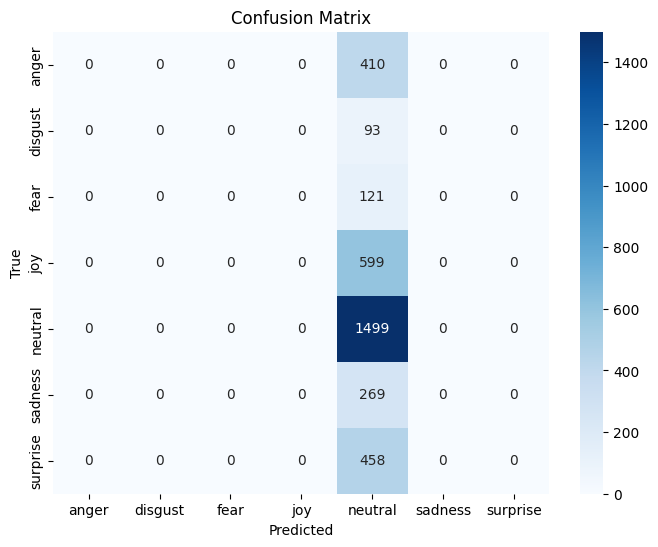

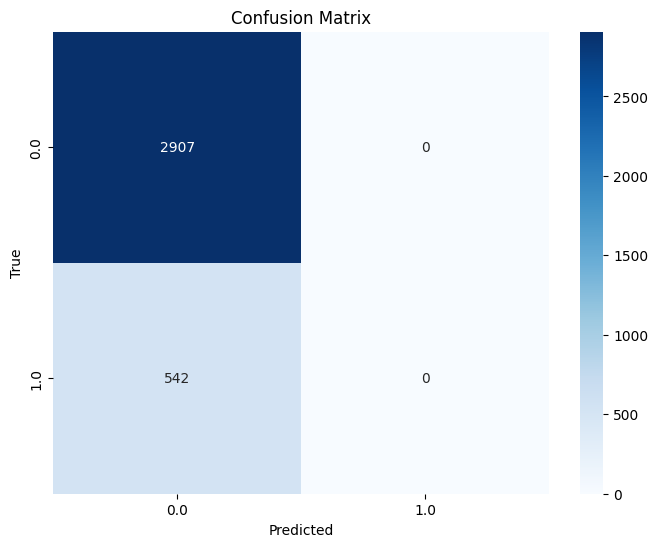

Metrics results in evaluating custom model
f1_seq_emotion: 0.41905890235682264
f1_flat_emotion: 0.43461873006668594
f1_seq_trigger: 0.7968414874529058
f1_flat_trigger: 0.8428530008698172



In [38]:
custom_metrics = trainer_standard.test(custom_model, show_cm = True)
print_descriptive(custom_metrics, source= 'custom model')

Error analysis


In [39]:
def generate_test_sample(df_standard, device, tokenizer, max_num_utterances):
    _, _, df_test = split_dataframe(df_standard, seed = 3)
    dataloader_test = create_dataloader(df_test, device, tokenizer, max_num_utterances, batch_size=1)
    dataiter = iter(dataloader_test)
    batch = next(dataiter)
    return batch

In [40]:
test_sample1 = generate_test_sample(df_standard, device, tokenizer, max_num_utterances)
test_sample2 = generate_test_sample(df_standard, device, tokenizer, max_num_utterances)

In [41]:
def show_comparison(test_sample):
  test_dialogue = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(test_sample[1][0]))
  test_dialogue_splitted = test_dialogue.split('[SEP]')
  test_emotions = emotions_onehotencoder.inverse_transform(test_sample[3][0].cpu().numpy())
  test_triggers = test_sample[4][0]
  token_type_ids, input_ids, attention_mask, emotions, triggers = test_sample
  emotions_pred, trigger_pred, dialogue_mask = custom_model(token_type_ids, input_ids, attention_mask, emotions, triggers)
  emotions_pred_onehot = discrete_to_onehot(torch.argmax(emotions_pred, dim = -1)[0], num_classes = len(emotions_onehotencoder.classes_))
  emotions_pred_labels = emotions_onehotencoder.inverse_transform(emotions_pred_onehot)
  trigger_pred = (trigger_pred[0]>0.5).float()
  for idx, (utterance, emotion, emotion_pred, trigger, trigger_pred) in enumerate(zip(test_dialogue_splitted, test_emotions, emotions_pred_labels, test_triggers, trigger_pred)):
      if dialogue_mask[0][idx] != 0.0:
        print('From Speaker {speak_num}: {utterance}'.format( speak_num = token_type_ids[0][idx], utterance= utterance))
        print('Emotion: {emotion}. Emotion predicted: {emotion_pred}.'.format(emotion=emotion, emotion_pred=emotion_pred))
        print('Trigger: {trigger}. Trigger predicted: {trigger_pred}.'.format(trigger = trigger.item(), trigger_pred=trigger_pred.item()))
        print()

In [42]:
show_comparison(test_sample1)

From Speaker 1: [CLS] hey ! hey ! be careful around my porsche ! 
Emotion: anger. Emotion predicted: neutral.
Trigger: 0.0. Trigger predicted: 0.0.

From Speaker 2:  hi joey . 
Emotion: neutral. Emotion predicted: neutral.
Trigger: 1.0. Trigger predicted: 0.0.

From Speaker 1:  hey ! how you doin ' ? 
Emotion: neutral. Emotion predicted: neutral.
Trigger: 0.0. Trigger predicted: 0.0.



In [43]:
show_comparison(test_sample2)

From Speaker 1: [CLS] so your dad dropped by . he ' s a pleasant man ! 
Emotion: joy. Emotion predicted: neutral.
Trigger: 0.0. Trigger predicted: 0.0.

From Speaker 2:  oh no 
Emotion: fear. Emotion predicted: neutral.
Trigger: 0.0. Trigger predicted: 0.0.

From Speaker 3:  i ' d better go . ( she goes and sits down in the 
Emotion: neutral. Emotion predicted: neutral.
Trigger: 0.0. Trigger predicted: 0.0.

From Speaker 2:  ross i ' m so sorry . okay . i - i will promise i will straighten this out with him tomorrow in person , or via e - mail . 
Emotion: sadness. Emotion predicted: neutral.
Trigger: 0.0. Trigger predicted: 0.0.

From Speaker 1:  i don ' t care about your dad ! i care about mona ! she was there and now she ' s totally freaked out ! 
Emotion: anger. Emotion predicted: neutral.
Trigger: 0.0. Trigger predicted: 0.0.

From Speaker 2:  oh okay , i ' ll fix that to . what ' s her e - mail address ? 
Emotion: neutral. Emotion predicted: neutral.
Trigger: 0.0. Trigger predicte